In [1]:
import pandas as pd
import numpy as np
import urllib.parse
import urllib.request
import certifi
import ssl
from Bio import SeqIO
from pathlib import Path
from collections import Counter
from Bio.Seq import Seq

In [2]:
uniprot = pd.read_csv('uniprot_ec1_prok_reviewed.tab',sep='\t')
uniprot.head()

,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM)
0,Q46G04,ACDA1_METBF,806,1.2.7.4,PF12838;PF03063;,Archaea
1,O59651,KATG2_HALMA,731,1.11.1.21,PF00141;,Archaea
2,Q6L047,GLCD2_PICTO,359,1.1.1.360,PF08240;PF16912;,Archaea
3,P72579,OFOB_SULSP,305,1.2.7.11,PF12367;PF02775;,Archaea
4,Q96Y68,OFOB1_SULTO,305,1.2.7.11,PF12367;PF02775;,Archaea


In [5]:
prok_uniprot = uniprot[(uniprot['Taxonomic lineage (SUPERKINGDOM)']=='Archaea') | (uniprot['Taxonomic lineage (SUPERKINGDOM)']=='Bacteria')]
print(len(prok_uniprot))
print(len(set(prok_uniprot['EC number'])))

23653
988


In [94]:
#how many oxidoreductases are there
len(set(uniprot['EC number']))

1668

# link uniprot IDs to EMBL CDS ids

In [4]:
print(len(uniprot))
print(len(set(uniprot['Entry'])))
print(len(set(uniprot['EC number'])))

33901
33901
1668


In [6]:
#use the uniprot mapper to go from uniprotkb_id to cds id

url = 'https://www.uniprot.org/uploadlists/'
    #query uniprot database mapper API, see: https://www.uniprot.org/help/api_idmapping

query = ' '.join(list(set(uniprot['Entry'])))
params = { 
'from': 'ACC+ID', #uniprot KB id
'to': 'EMBL', #EMBL/GenBank/DDBJ CDS
'format': 'tab', 
'query': query
} 

data = urllib.parse.urlencode(params) 
data = data.encode('utf-8') 
req = urllib.request.Request(url, data) 
with urllib.request.urlopen(req, context=ssl.create_default_context(cafile=certifi.where())) as f: 
    response = f.read() 

"\n#use the uniprot mapper to go from uniprotkb_id to cds id\n\nurl = 'https://www.uniprot.org/uploadlists/'\n    #query uniprot database mapper API, see: https://www.uniprot.org/help/api_idmapping\n\nquery = ' '.join(list(set(uniprot['Entry'])))\nparams = { \n'from': 'ACC+ID', #uniprot KB id\n'to': 'EMBL', #EMBL/GenBank/DDBJ CDS\n'format': 'tab', \n'query': query\n} \n\ndata = urllib.parse.urlencode(params) \ndata = data.encode('utf-8') \nreq = urllib.request.Request(url, data) \nwith urllib.request.urlopen(req, context=ssl.create_default_context(cafile=certifi.where())) as f: \n    response = f.read() \n"

In [5]:
fout = 'ec1_uniprot2cds.tsv'
with open(fout,'w') as f:
    f.writelines(response.decode('utf-8')) 

In [7]:
uniprot2cds = pd.read_csv('ec1_uniprot2cds.tsv',sep='\t')
print(len(uniprot2cds))
uniprot2cds.columns = ['Entry','EMBL_CDS_id']
uniprot2cds.head()

53258


,Entry,EMBL_CDS_id
0,Q60HE5,BAD51970.1
1,A0A1D6F9Y9,ONM27923.1
2,A0A1D6F9Y9,ACF85239.1
3,A0A1D6F9Y9,ACL53859.1
4,A0A1D6F9Y9,ACR36247.1


In [8]:
merged = uniprot.merge(uniprot2cds,on='Entry')

In [9]:
print(len(merged))
merged.head()

53258


,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),EMBL_CDS_id
0,Q46G04,ACDA1_METBF,806,1.2.7.4,PF12838;PF03063;,Archaea,AAZ69188.1
1,O59651,KATG2_HALMA,731,1.11.1.21,PF00141;,Archaea,CAA76423.1
2,O59651,KATG2_HALMA,731,1.11.1.21,PF00141;,Archaea,AAV46121.1
3,Q6L047,GLCD2_PICTO,359,1.1.1.360,PF08240;PF16912;,Archaea,AAT43655.1
4,P72579,OFOB_SULSP,305,1.2.7.11,PF12367;PF02775;,Archaea,BAA10899.1


In [16]:
Counter(merged['Taxonomic lineage (SUPERKINGDOM)'])

Counter({'Archaea': 1408,
         'Eukaryota': 24935,
         'Bacteria': 26741,
         'Viruses': 174})

## link uniprot ids to uniref50 ids

In [10]:
import urllib.parse
import urllib.request

url = 'https://www.uniprot.org/uploadlists/'
query = ' '.join(list(set(merged['Entry'])))

params = {
'from': 'ACC+ID',
'to': 'NF50',
'format': 'tab',
'query': query
}

data = urllib.parse.urlencode(params) 
data = data.encode('utf-8') 
req = urllib.request.Request(url, data) 
with urllib.request.urlopen(req, context=ssl.create_default_context(cafile=certifi.where())) as f: 
    response = f.read() 

In [11]:
fout = 'ec1_uniprot2uniref50.tsv'
with open(fout,'w') as f:
    f.writelines(response.decode('utf-8')) 

# split into train/valid/test set

split so each ec number goes in either train, valid, or test; but not overlapping (see GH data gathering for example)

OR

split so each uniref50 cluster goes in either train, valid, or test; but not overlapping

In [15]:
clusters = pd.read_csv('ec1_uniprot2uniref50.tsv',sep='\t')
clusters.columns = ['Entry','uniref50id']
print(len(clusters))
clusters.head()

33386


,Entry,uniref50id
0,P9WKD5,UniRef50_Q9CCE3
1,Q6FFZ7,UniRef50_C9QZ64
2,B2UX78,UniRef50_A0PXA4
3,Q3SV33,UniRef50_B8EKI5
4,B1M4X4,UniRef50_B1M4X4


In [17]:
print(len(set(clusters['uniref50id'])))

10127


In [38]:
ecmerged = clusters.merge(merged[['Entry','EC number','Taxonomic lineage (SUPERKINGDOM)', 'EMBL_CDS_id']])

In [39]:
print(len(ecmerged))
print(len(ecmerged.dropna()))
print(len(set(ecmerged['uniref50id'])))
print(len(set(ecmerged['Entry'])))
print(len(set(ecmerged['EC number'])))
print(Counter(ecmerged['Taxonomic lineage (SUPERKINGDOM)']))
print(len(ecmerged[(ecmerged['Taxonomic lineage (SUPERKINGDOM)']=='Bacteria') | (ecmerged['Taxonomic lineage (SUPERKINGDOM)']=='Archaea')]))


53258
53258
10127
33386
1646
Counter({'Bacteria': 26741, 'Eukaryota': 24935, 'Archaea': 1408, 'Viruses': 174})
28149


In [40]:
ecmerged = ecmerged[(ecmerged['Taxonomic lineage (SUPERKINGDOM)']=='Bacteria') | (ecmerged['Taxonomic lineage (SUPERKINGDOM)']=='Archaea')]
print(len(ecmerged))
print(len(ecmerged.dropna()))
print(len(set(ecmerged['uniref50id'])))
print(len(set(ecmerged['Entry'])))
print(len(set(ecmerged['EC number'])))
print(Counter(ecmerged['Taxonomic lineage (SUPERKINGDOM)']))


28149
28149
5451
23497
972
Counter({'Bacteria': 26741, 'Archaea': 1408})


In [41]:
ecmerged.head()

,Entry,uniref50id,EC number,Taxonomic lineage (SUPERKINGDOM),EMBL_CDS_id
0,P9WKD5,UniRef50_Q9CCE3,1.10.3.-,Bacteria,CCP44925.1
1,Q6FFZ7,UniRef50_C9QZ64,1.14.99.46,Bacteria,CAG67010.1
2,B2UX78,UniRef50_A0PXA4,1.2.1.41,Bacteria,ACD53888.1
3,Q3SV33,UniRef50_B8EKI5,1.8.1.2,Bacteria,ABA03858.1
4,B1M4X4,UniRef50_B1M4X4,1.7.1.17,Bacteria,ACB26435.1


In [73]:
ecmerged.to_csv('EC1_merged2cds2uniref.csv',index=False)
ecmerged = pd.read_csv('EC1_merged2cds2uniref.csv')
ecmerged.head()

,Entry,uniref50id,EC number,Taxonomic lineage (SUPERKINGDOM),EMBL_CDS_id
0,P9WKD5,UniRef50_Q9CCE3,1.10.3.-,Bacteria,CCP44925.1
1,Q6FFZ7,UniRef50_C9QZ64,1.14.99.46,Bacteria,CAG67010.1
2,B2UX78,UniRef50_A0PXA4,1.2.1.41,Bacteria,ACD53888.1
3,Q3SV33,UniRef50_B8EKI5,1.8.1.2,Bacteria,ABA03858.1
4,B1M4X4,UniRef50_B1M4X4,1.7.1.17,Bacteria,ACB26435.1


In [42]:
for ec in list(set(ecmerged['EC number']))[0:5]:
    subset = ecmerged[ecmerged['EC number']==ec]
    print(Counter(subset['uniref50id']))
    print(subset)
#it's the case that same ec often has multiple uniref clusters

Counter({'UniRef50_P9WQP6': 2})
        Entry       uniref50id           EC number  \
22595  P9WQP6  UniRef50_P9WQP6  1.1.1.145; 5.3.3.1   
27471  P9WQP7  UniRef50_P9WQP6  1.1.1.145; 5.3.3.1   

      Taxonomic lineage (SUPERKINGDOM) EMBL_CDS_id  
22595                         Bacteria  AAK45394.1  
27471                         Bacteria  CCP43859.1  
Counter({'UniRef50_Q51698': 1, 'UniRef50_Q51697': 1})
        Entry       uniref50id  EC number Taxonomic lineage (SUPERKINGDOM)  \
70     Q51698  UniRef50_Q51698  1.3.99.16                         Bacteria   
36966  Q51697  UniRef50_Q51697  1.3.99.16                         Bacteria   

      EMBL_CDS_id  
70     CAA88754.1  
36966  CAA88753.1  
Counter({'UniRef50_P43127': 4, 'UniRef50_Q9HUX5': 2, 'UniRef50_P0A394': 2, 'UniRef50_O85012': 2, 'UniRef50_P94680': 2, 'UniRef50_Q8CKU7': 2, 'UniRef50_Q92ZM6': 1, 'UniRef50_Q9L6L9': 1})
            Entry       uniref50id EC number Taxonomic lineage (SUPERKINGDOM)  \
2272       Q9HUX5  UniRef50_Q9

In [43]:
def get_split_df(df,column_to_split,val_pct,test_pct):
    valid_target_length = int(len(df)*val_pct)
    test_target_length = int(len(df)*test_pct)
    print('ideally, there will be 10% in valid set of both nrows and number of cats:',valid_target_length,int(len(set(df[column_to_split]))*val_pct))
    print('ideally, there will be 5% in test set of both nrows and number of cats:',test_target_length,int(len(set(df[column_to_split]))*test_pct))
    
    train = pd.DataFrame()
    valid = pd.DataFrame()
    test = pd.DataFrame()

    for cat in set(df[column_to_split]):
        subset = df[df[column_to_split]==cat]
        if len(test)<test_target_length:
            test = test.append(subset)
        elif len(valid)<valid_target_length:
            valid = valid.append(subset)
        else:
            train = train.append(subset)
            
    print('length original df:',len(df),'; number cats:',len(set(df[column_to_split])))
    print('length train:',len(train),'; number cats:',len(set(train[column_to_split])))
    print('length valid:',len(valid),'; number cats:',len(set(valid[column_to_split])))
    print('length test:',len(test),'; number cats:',len(set(test[column_to_split])))
    
    
    return train,valid,test

In [44]:
ec1_train,ec1_valid,ec1_test = get_split_df(ecmerged,'uniref50id',0.1,0.05)

ideally, there will be 10% in valid set of both nrows and number of cats: 2814 545
ideally, there will be 5% in test set of both nrows and number of cats: 1407 272
length original df: 28149 ; number cats: 5451
length train: 23924 ; number cats: 4642
length valid: 2815 ; number cats: 557
length test: 1410 ; number cats: 252


In [45]:
ec1_train.head()

,Entry,uniref50id,EC number,Taxonomic lineage (SUPERKINGDOM),EMBL_CDS_id
27460,O05616,UniRef50_O05616,1.14.13.82,Bacteria,CAA72287.1
40904,P12609,UniRef50_O05616,1.14.13.82,Bacteria,AAA26019.1
40956,Q8GAZ4,UniRef50_Q8GAZ4,1.14.12.17,Bacteria,BAC16771.1
15330,Q8P3K4,UniRef50_Q561X9,1.1.1.-,Bacteria,AAM43288.1
2464,A0R665,UniRef50_Q7TVI2,1.14.13.-,Bacteria,ABK75948.1


In [46]:
def get_seqs(ids,fout):
    #need do it in chunks of 500
    starts = list(np.arange(0,len(ids),500))
    stops = list(np.arange(500,len(ids),500))+[len(ids)]
    root = 'https://www.ebi.ac.uk/ena/browser/api/fasta/'
    
    for ix in range(0,len(starts)):
        url = root+','.join(ids[starts[ix]:stops[ix]])
        response = urllib.request.urlopen(url, context=ssl.create_default_context(cafile=certifi.where())).read().decode('utf-8')
        with open(fout,'a') as f:
            f.writelines(response)

In [47]:
print('getting valid set ec1 label')
get_seqs(list(ec1_valid['EMBL_CDS_id']),fout='ec1_valid.fasta')

print('getting test set ec1 label')
get_seqs(list(ec1_test['EMBL_CDS_id']),fout='ec1_test.fasta')

print('getting train set ec1 label')
get_seqs(list(ec1_train['EMBL_CDS_id']),fout='ec1_train.fasta')

getting valid set ec1 label
getting test set ec1 label
getting train set ec1 label


## repeat train/valid/test split for non-ec1s

In [48]:
swissprot = pd.read_csv('../uniprot_reviewed.tab',sep='\t')
print(len(swissprot))
swissprot = swissprot.dropna(subset=['EC number'])
print(len(swissprot))
swissprot.head()

562253
268373


,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy)
0,Q4R8P0,ABHGA_MACFA,558,3.1.-.-; 3.1.1.23,PF00561;,Eukaryota,NaN
1,P03949,ABL1_CAEEL,1224,2.7.10.2,PF08919;PF07714;PF00017;PF00018;,Eukaryota,NaN
3,P31937,3HIDH_HUMAN,336,1.1.1.31,PF14833;PF03446;,Eukaryota,NaN
4,Q9FFR3,6PGD3_ARATH,487,1.1.1.44,PF00393;PF03446;,Eukaryota,NaN
7,Q61503,5NTD_MOUSE,576,3.1.3.5,PF02872;PF00149;,Eukaryota,NaN


In [59]:
nonec1 = swissprot[~swissprot['EC number'].str.startswith('1.')]
print(len(nonec1))
print(len(set(nonec1['EC number'])))

235301
4501


In [64]:
#take random subset with equal number cds ids
nonec1 = nonec1.sample(len(ecmerged))
print(len(ecmerged))
print(len(nonec1))
print(len(set(nonec1['EC number'])))
nonec1.head()

28149
28149
2235


,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy)
319471,B0XMZ5,LCL3_ASPFC,296,3.1.-.-,PF00565;,Eukaryota,NaN
133083,Q64UB9,PANB_BACFR,273,2.1.2.11,PF02548;,Bacteria,NaN
236587,B8I164,METAA_RUMCH,306,2.3.1.31,PF04204;,Bacteria,NaN
311727,Q3SEU8,HIS6_THIDA,251,4.3.2.10,PF00977;,Bacteria,NaN
292790,B2UVE0,FABZ_HELPS,159,4.2.1.59,PF07977;,Bacteria,NaN


In [65]:
#link to cds
#use the uniprot mapper to go from uniprotkb_id to cds id

url = 'https://www.uniprot.org/uploadlists/'
    #query uniprot database mapper API, see: https://www.uniprot.org/help/api_idmapping

query = ' '.join(list(set(nonec1['Entry'])))
params = { 
'from': 'ACC+ID', #uniprot KB id
'to': 'EMBL', #EMBL/GenBank/DDBJ CDS
'format': 'tab', 
'query': query
} 

data = urllib.parse.urlencode(params) 
data = data.encode('utf-8') 
req = urllib.request.Request(url, data) 
with urllib.request.urlopen(req, context=ssl.create_default_context(cafile=certifi.where())) as f: 
    response = f.read() 

In [66]:
fout = 'nonec1_uniprot2cds.tsv'
with open(fout,'w') as f:
    f.writelines(response.decode('utf-8')) 

In [67]:
#merge with original df
nonec1cds = pd.read_csv('nonec1_uniprot2cds.tsv',sep='\t')
nonec1cds.columns = ['Entry','EMBL_CDS_id']
nonec1merged = nonec1.merge(nonec1cds,on='Entry')

In [69]:
print(len(nonec1merged))
nonec1merged.head()

40427


,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy),EMBL_CDS_id
0,B0XMZ5,LCL3_ASPFC,296,3.1.-.-,PF00565;,Eukaryota,NaN,EDP55687.1
1,Q64UB9,PANB_BACFR,273,2.1.2.11,PF02548;,Bacteria,NaN,BAD48910.1
2,B8I164,METAA_RUMCH,306,2.3.1.31,PF04204;,Bacteria,NaN,ACL77620.1
3,Q3SEU8,HIS6_THIDA,251,4.3.2.10,PF00977;,Bacteria,NaN,AAZ97661.1
4,B2UVE0,FABZ_HELPS,159,4.2.1.59,PF07977;,Bacteria,NaN,ACD48822.1


In [70]:
#link with uniref50
import urllib.parse
import urllib.request

url = 'https://www.uniprot.org/uploadlists/'
query = ' '.join(list(set(nonec1merged['Entry'])))

params = {
'from': 'ACC+ID',
'to': 'NF50',
'format': 'tab',
'query': query
}

data = urllib.parse.urlencode(params) 
data = data.encode('utf-8') 
req = urllib.request.Request(url, data) 
with urllib.request.urlopen(req, context=ssl.create_default_context(cafile=certifi.where())) as f: 
    response = f.read() 

In [71]:
fout = 'nonec1_uniprot2uniref50.tsv'
with open(fout,'w') as f:
    f.writelines(response.decode('utf-8')) 

In [74]:
nonec1clusters = pd.read_csv('nonec1_uniprot2uniref50.tsv',sep='\t')
nonec1clusters.columns = ['Entry','uniref50id']
print(len(nonec1clusters))
nonec1clusters.head()

27864


,Entry,uniref50id
0,Q5AQL1,UniRef50_P40825
1,A1S4U5,UniRef50_Q8ECL7
2,A7ZAL8,UniRef50_Q45601
3,A3KFX0,UniRef50_Q9BXI3
4,A9WV65,UniRef50_Q4JXF0


In [79]:
nonecmerged = nonec1clusters.merge(nonec1merged[['Entry','EC number','Taxonomic lineage (SUPERKINGDOM)', 'EMBL_CDS_id']])
print(len(nonecmerged))
print(len(set(nonecmerged['uniref50id'])))
print(len(set(ecmerged['uniref50id'])))
nonecmerged = nonecmerged.sample(len(ecmerged))
print(len(nonecmerged))
print(len(set(nonecmerged['uniref50id'])))
nonecmerged.head()

40427
16218
5451
28149
13248


,Entry,uniref50id,EC number,Taxonomic lineage (SUPERKINGDOM),EMBL_CDS_id
1105,P19938,UniRef50_P19938,2.6.1.21,Bacteria,AAA22252.1
24850,Q82EU4,UniRef50_Q82EU4,2.5.1.16,Bacteria,BAC72231.1
10253,Q7VE17,UniRef50_P27724,7.1.1.-,Bacteria,AAP99243.1
30582,P0C7K7,UniRef50_Q4ZUD2,3.5.1.5,Bacteria,AAD28136.2
35493,B7LZZ6,UniRef50_Q65V59,5.3.1.12,Bacteria,CAR00052.1


In [80]:
nonecmerged.to_csv('nonEC1_merged2cds2uniref.csv',index=False)
nonecmerged = pd.read_csv('nonEC1_merged2cds2uniref.csv')
nonecmerged.head()

,Entry,uniref50id,EC number,Taxonomic lineage (SUPERKINGDOM),EMBL_CDS_id
0,P19938,UniRef50_P19938,2.6.1.21,Bacteria,AAA22252.1
1,Q82EU4,UniRef50_Q82EU4,2.5.1.16,Bacteria,BAC72231.1
2,Q7VE17,UniRef50_P27724,7.1.1.-,Bacteria,AAP99243.1
3,P0C7K7,UniRef50_Q4ZUD2,3.5.1.5,Bacteria,AAD28136.2
4,B7LZZ6,UniRef50_Q65V59,5.3.1.12,Bacteria,CAR00052.1


In [81]:
#split
nonec1_train,nonec1_valid,nonec1_test = get_split_df(nonecmerged,'uniref50id',0.1,0.05)

ideally, there will be 10% in valid set of both nrows and number of cats: 2814 1324
ideally, there will be 5% in test set of both nrows and number of cats: 1407 662
length original df: 28149 ; number cats: 13248
length train: 23915 ; number cats: 11192
length valid: 2817 ; number cats: 1377
length test: 1417 ; number cats: 679


In [83]:
#get seqs
print('getting valid set nonec1 label')
get_seqs(list(nonec1_valid['EMBL_CDS_id']),fout='nonec1_valid.fasta')

print('getting test set nonec1 label')
get_seqs(list(nonec1_test['EMBL_CDS_id']),fout='nonec1_test.fasta')

print('getting train set nonec1 label')
get_seqs(list(nonec1_train['EMBL_CDS_id']),fout='nonec1_train.fasta')

getting valid set nonec1 label
getting test set nonec1 label
getting train set nonec1 label


# get clean csv

In [84]:
def generate_chunked_reads(seq, distrib, num_reads):
    chunked_seqs = []
    for read in range(0,num_reads):
        #pick random start position, don't let it start farther than 60nt from end so all the reads are at least that long
        start = np.random.choice(range(0,len(seq)-60))
        if start < 0:
            start=0
        seqlen = int(np.random.choice(distrib))
        end = start+seqlen
        sequence = seq[start:end]
        #IRL, gene is equally likely to be sequenced in either forward or reverse direction. Toss a coin which to use
        use_complement = np.random.choice([0,1])
        if use_complement:
            subseq = str(Seq(sequence).reverse_complement())
        else:
            subseq = sequence
        chunked_seqs.append(subseq)
        
    return chunked_seqs
            
def get_reads_for_label(records, in_path, label, distrib, num_reads):
    for record in SeqIO.parse(in_path,"fasta"): 
        seq = str(record.seq)
        #retrieve cds id from description
        cds_id = record.description.split('|')[2].split(' ')[0]
        start = 0
        end = len(seq)
        if len(seq)>60: #occasionally there are sequence differences between cds and uniprot entry (intron retention in uniprot). ignore these.
            #generate num_reads read-length chunks from range
            chunked_seqs = generate_chunked_reads(seq,distrib,num_reads=num_reads)
            for read in chunked_seqs:        
                entry = [cds_id, read, label]
                records.append(entry)
    return records

def create_csv(outfile, in_pos_path, in_neg_path, pos_label, neg_label, distrib, num_pos_genes, num_neg_reads=20, num_pos_reads=None):
    #for each of these files, extract the reads, and the labels from the filename
    records = []
    
    records = get_reads_for_label(records, in_path=in_neg_path, label=neg_label, distrib=distrib, num_reads=num_neg_reads)
    #get equal number examples metal 
    if not num_pos_reads: #if no num_pos_reads specified, get equal number
        num_pos_reads = int(len(records)/num_pos_genes)+1
    records = get_reads_for_label(records=records, in_path=in_pos_path, label=pos_label, distrib=distrib, num_reads=num_pos_reads)

    #shuffle records and save
    outdf = pd.DataFrame(records)
    outdf = outdf.sample(frac=1)
    outdf.columns = ['EMBL_CDS_id','seq','label']
    print('saving',len(outdf),'rows in file',outfile,':')
    print(outdf.head())
    print(Counter(outdf['label']))
    outdf.to_csv(outfile,index=False)

In [85]:
distrib = np.load('../GTDBGenomeSequencingDistrib.npy')

train_pos_path = Path('ec1_train.fasta')
train_neg_path = Path('nonec1_train.fasta')
valid_pos_path = Path('ec1_valid.fasta')
valid_neg_path = Path('nonec1_valid.fasta')
test_pos_path = Path('ec1_test.fasta')
test_neg_path = Path('nonec1_test.fasta')

trnout = Path('ec1_train.csv')
valout = Path('ec1_valid.csv')
testout = Path('ec1_test.csv')

In [89]:
#save valid
#check num_pos_genes by running `grep -c "^>" ec1_valid.fasta`
create_csv(outfile=valout, in_pos_path=valid_pos_path, in_neg_path=valid_neg_path, 
                 pos_label='ec1',neg_label='nonec1',
                 distrib=distrib, num_pos_genes=2796, num_neg_reads=50)


saving 279200 rows in file ec1_valid.csv :
       EMBL_CDS_id                                                seq   label
197822  BAB41593.1  TCCCATTTAGCTGGGCATACTTCGCCAGGGTTTTTACGAACATATT...     ec1
128835  DAA08282.1  GAAAATACTTTTAAATATATGTTTAACAAGGGAATCGGAACAAAGC...  nonec1
5790    ABG48470.1  TCTGTTTCCTGTCTTCTTTGGATAAACTCATCAGCAACCCTGGTAC...  nonec1
122765  EDM14285.1  TCCTCCAGATGCAGGCGGTCCAGCATTTCATAAACTATGGTTTCCC...  nonec1
78907   CAA88763.1  AGGAATTTTGGCTGCTATCAACACCGTAAGAACCGGAATAGCTGAT...  nonec1
Counter({'ec1': 139600, 'nonec1': 139600})


In [7]:
139600+139600

279200

In [90]:
#save test
#check num_pos_genes by running `grep -c "^>" ec1_valid.fasta`
create_csv(outfile=testout, in_pos_path=test_pos_path, in_neg_path=test_neg_path, 
                 pos_label='ec1',neg_label='nonec1',
                 distrib=distrib, num_pos_genes=1403, num_neg_reads=50)


saving 141801 rows in file ec1_test.csv :
      EMBL_CDS_id                                                seq   label
12848  AAL98442.1  TGCTTTGGAAGATGGACAAGTTCTTTTGGTTGAAAACACTCGTTTT...  nonec1
48039  CAM85356.1  ATGACACGACTACCAAATGCTAAAACCGTAATCTGCTCATCACTGT...  nonec1
50210  CAC14144.1  GCGTGCCTCTATGGCGCCGGGGCCGCTGATCCCATCATGTCGAACC...  nonec1
83232  AAC18585.1  TGGCCAAGGATCTGCGTTTCGCCCAGCACCATCGAATCCAGGCCGC...     ec1
23477  AAQ66230.1  TGATCGATCGTCTCAAGTTTGTACTCGAAAAGCCATTTGTTCGTTT...  nonec1
Counter({'ec1': 71451, 'nonec1': 70350})


In [8]:
71451+70350

141801

In [91]:
#save train
#check num_pos_genes by running `grep -c "^>" ec1_valid.fasta`
create_csv(outfile=trnout, in_pos_path=train_pos_path, in_neg_path=train_neg_path, 
                 pos_label='ec1',neg_label='nonec1',
                 distrib=distrib, num_pos_genes=23776, num_neg_reads=50)

saving 2372200 rows in file ec1_train.csv :
        EMBL_CDS_id                                                seq   label
987705   CAA33481.1  CCCTTCTTTCAAATTATTATATTTAATGGATGAAGTAATGGATCCT...  nonec1
1600848  AAC06140.1  GGCCGGCGCTTATATCTGCGGCGACGAATCGGCGCTCATCGAGTCC...     ec1
496155   AAL19864.1  CTTTTGAAACAAAAGATTTTGGAAAAACATGGACTGAGTTTCCTCC...  nonec1
785044   BAB51542.1  ACGCGCGCGGTGGTCGATTTGCCGACGGCGACGGAGCCGGCGATGC...  nonec1
2294664  CAG39732.1  GGAACCTGGACAAAAAGCCAAAATAGAAGTGGTTTTTAAAAATACT...     ec1
Counter({'ec1': 1187150, 'nonec1': 1185050})


In [6]:
1187150+1185050

2372200

In [2]:
test = pd.read_csv('ec1_test.csv')
test_ec1 = test[test['label']=='ec1']
print(len(test_ec1))
print(len(set(test_ec1['EMBL_CDS_id'])))

71451
1401


In [7]:
valid = pd.read_csv('ec1_valid.csv')
valid_ec1 = valid[valid['label']=='ec1']
print(len(valid_ec1))
print(len(set(valid_ec1['EMBL_CDS_id'])))

139600
2792


In [3]:
ecmerged = pd.read_csv('EC1_merged2cds2uniref.csv')
ecmerged.head()

,Entry,uniref50id,EC number,Taxonomic lineage (SUPERKINGDOM),EMBL_CDS_id
0,P9WKD5,UniRef50_Q9CCE3,1.10.3.-,Bacteria,CCP44925.1
1,Q6FFZ7,UniRef50_C9QZ64,1.14.99.46,Bacteria,CAG67010.1
2,B2UX78,UniRef50_A0PXA4,1.2.1.41,Bacteria,ACD53888.1
3,Q3SV33,UniRef50_B8EKI5,1.8.1.2,Bacteria,ABA03858.1
4,B1M4X4,UniRef50_B1M4X4,1.7.1.17,Bacteria,ACB26435.1


In [4]:
testmerged = test_ec1.merge(ecmerged[['EC number','EMBL_CDS_id']],on='EMBL_CDS_id')
print(len(testmerged))
testmerged.head()

71451


,EMBL_CDS_id,seq,label,EC number
0,AAC18585.1,TGGCCAAGGATCTGCGTTTCGCCCAGCACCATCGAATCCAGGCCGC...,ec1,1.2.1.70
1,AAC18585.1,AAGCGTTTGCAGCCAGTTCGCAAACACCTGCATTTCCTCTTCGATC...,ec1,1.2.1.70
2,AAC18585.1,GAGCGGACGAAGTTATCGTCGCCAACCGGACCTATGCCCGCGCCCA...,ec1,1.2.1.70
3,AAC18585.1,TTGGCGGCGAGCTCCTGGGCGCGGGCATAGGTCCGGTTGGCGACGA...,ec1,1.2.1.70
4,AAC18585.1,ACTGCACATGTGCGGGTATTTTATCCGCAGCTTTATGGAACGCTGG...,ec1,1.2.1.70


In [5]:
len(set(testmerged['EC number']))

139

In [6]:
len(set(ecmerged['EC number']))

972

In [8]:
validmerged = valid_ec1.merge(ecmerged[['EC number','EMBL_CDS_id']],on='EMBL_CDS_id')
print(len(validmerged))
print(len(set(validmerged['EC number'])))
validmerged.head()

139600
253


,EMBL_CDS_id,seq,label,EC number
0,BAB41593.1,TCCCATTTAGCTGGGCATACTTCGCCAGGGTTTTTACGAACATATT...,ec1,1.11.1.15
1,BAB41593.1,TTTTGTAAGTCTTCTAATTCAGTTGGACAAACGAATGAGAAGTCAG...,ec1,1.11.1.15
2,BAB41593.1,TTCTCATTCGTTTGTCCAACTGAATTAGAAGACTTACAAAACCAAT...,ec1,1.11.1.15
3,BAB41593.1,TTAGCTCAACGTGGTACATTCATTATCGACCCAGACGGTGTTGTAC...,ec1,1.11.1.15
4,BAB41593.1,GTAATTTTGATGTATTAGATGAAGCTACTGGTTTAGCTCAACGTGG...,ec1,1.11.1.15


In [29]:
from itertools import combinations
from Bio import pairwise2

def get_combos(combos,df,colname):
    new_combos = []
    for combo in combos:
        a = df.loc[combo[0]][colname]
        b = df.loc[combo[1]][colname]
        new_combos.append((a,b))
    return new_combos

def score_alignment(combo):
    alignment = pairwise2.align.localms(combo[0],combo[1],1,-1,-10.0,-1.0)
    ix = np.argmax([a[2] for a in alignment])
    max_score = alignment[ix][2]
    #ungapped_alignment_length = get_ungapped_alignment_length(alignment[ix])
    return max_score


In [30]:
#what's the average within-EC seq similarity?
scores = []
for ecx,EC in enumerate(set(testmerged['EC number'])):
    print('processing EC',ecx,'out of',len(set(testmerged['EC number'])))
    subset = testmerged[testmerged['EC number']==EC]
    samp = subset.sample(20,random_state=1)
    combo_ix = list(combinations(list(samp.index),2))
    combos = get_combos(combo_ix, samp, colname='seq')
    for ix,combo in enumerate(combos):
        score = score_alignment(combo)
        row = [combo_ix[ix][0],combo_ix[ix][1],EC,score]
        scores.append(row)

processing EC 0 out of 139
processing EC 1 out of 139
processing EC 2 out of 139
processing EC 3 out of 139
processing EC 4 out of 139
processing EC 5 out of 139
processing EC 6 out of 139
processing EC 7 out of 139
processing EC 8 out of 139
processing EC 9 out of 139
processing EC 10 out of 139
processing EC 11 out of 139
processing EC 12 out of 139
processing EC 13 out of 139
processing EC 14 out of 139
processing EC 15 out of 139
processing EC 16 out of 139
processing EC 17 out of 139
processing EC 18 out of 139
processing EC 19 out of 139
processing EC 20 out of 139
processing EC 21 out of 139
processing EC 22 out of 139
processing EC 23 out of 139
processing EC 24 out of 139
processing EC 25 out of 139
processing EC 26 out of 139
processing EC 27 out of 139
processing EC 28 out of 139
processing EC 29 out of 139
processing EC 30 out of 139
processing EC 31 out of 139
processing EC 32 out of 139
processing EC 33 out of 139
processing EC 34 out of 139
processing EC 35 out of 139
pr

In [32]:
scores = pd.DataFrame(scores)
scores.columns = ['a_ix','b_ix','EC number','seqsim']
scores.head()

,a_ix,b_ix,EC number,seqsim
0,15067,15047,1.6.5.2,10.0
1,15067,15094,1.6.5.2,45.0
2,15067,15071,1.6.5.2,10.0
3,15067,15078,1.6.5.2,9.0
4,15067,15089,1.6.5.2,84.0


In [33]:
print(np.percentile(scores['seqsim'],10))
print(np.percentile(scores['seqsim'],25))
print(np.percentile(scores['seqsim'],50))
print(np.percentile(scores['seqsim'],75))
print(np.percentile(scores['seqsim'],90))

7.0
7.0
9.0
10.0
20.0


In [36]:
print(np.mean(scores['seqsim']))
print(np.median(scores['seqsim']))

14.85831124574025
9.0


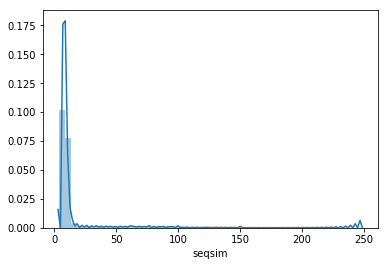

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.distplot(scores['seqsim'])